In [1]:
import os
from tqdm.notebook import tqdm
import pandas
import numpy
import matplotlib.pyplot as plt

from ProblemInstance import ProblemInstance
from baseline_intra import bl_intra_1
from baseline_request import bl_req_FCFS
from baseline_pslice import bl_pslice
from baseline_pimlet import bl_pimlet
from our_approach import leader_follower

In [2]:
predef_N_X = numpy.array([
    12000, # 0 cDeepArchContext
    400,   # 1 cDeepArchContext
    15600, # 2 DeepEarInputLayer
    12000, # 3 DeepEarAmbientScene
    3600,  # 4 DeepEarStress
    3600,  # 5 DeepEarEmotion
    3600,  # 6 DeepEarSpeaker
    512,   # 7 GaitExtractor
    90808, # 8 GaitIdentifierCNN
    15608, # 9 GaitIdentifierLSTM
    15608, # 10 GaitIdentifierFC  
    15200, # 11 GaitAuthenticLSTM 
    1000,   # 12 LeNet
    1000,   # 13 AlexNet
    1000,   # 14 VGG8
    1000,   # 15 ResNet18
    1000,   # 16 DenseNet40
    1000,   # 17 LSTM
])

fontsize = 15
neurosim_dir = "NetStructure/"
summary_file = "NeuroSIMOut/summary.csv"
figure_dir = "figures/"
color_map = ["#ff8884", "indianred", "#f8ac8c",  "#2878b5", '#80b1d3', "#9ac9db"]
predef_N_X = numpy.array([12000, 400, 15600, 12000, 3600, 3600, 3600, 512, 90808, 
                          15608, 15608, 15200, 1000, 1000, 1000, 1000, 1000, 1000,])

In [3]:
def get_time(problem, plan): 
    return problem.running_time_decompose(*problem.get_pc_packages_from_plan(*plan))

In [4]:
# seed = 1
seed_set = numpy.arange(100)
multi_model_problem = ProblemInstance(neurosim_dir)
multi_model_problem.read_nn_profile(summary_file)
N_M = multi_model_problem.N_M
nn_ids = numpy.arange(N_M)
nmrange = numpy.arange(2, N_M+1)


intra_read_time = numpy.zeros_like(nmrange).astype(float)
inter_read_time = numpy.zeros_like(nmrange).astype(float)
pslice_read_time = numpy.zeros_like(nmrange).astype(float)
pimlet_read_time = numpy.zeros_like(nmrange).astype(float)
our_read_time = numpy.zeros_like(nmrange).astype(float)

intra_write_time = numpy.zeros_like(nmrange).astype(float)
inter_write_time = numpy.zeros_like(nmrange).astype(float)
pslice_write_time = numpy.zeros_like(nmrange).astype(float)
pimlet_write_time = numpy.zeros_like(nmrange).astype(float)
our_write_time = numpy.zeros_like(nmrange).astype(float)


nn_ids = numpy.arange(N_M)
for seed in tqdm(seed_set):
    numpy.random.seed(seed)
    numpy.random.shuffle(nn_ids)
    for i, n_m in enumerate(nmrange):
        nn = nn_ids[:n_m]
        multi_model_problem.get_exact_requests(nn_ids=nn, n_x=predef_N_X[nn])

        plan_intra = bl_intra_1(multi_model_problem)
        time_intra = get_time(multi_model_problem, plan_intra)
        intra_read_time[i] += time_intra["read latency"]
        intra_write_time[i] += time_intra["write latency"]

        package_inter = bl_req_FCFS(multi_model_problem) 
        time_inter = multi_model_problem.running_time_decompose(*package_inter)
        inter_read_time[i] += time_inter["read latency"]
        inter_write_time[i] += time_inter["write latency"]

        plan_pslice = bl_pslice(multi_model_problem)
        time_pslice = get_time(multi_model_problem, plan_pslice)
        pslice_read_time[i] += time_pslice["read latency"]
        pslice_write_time[i] += time_pslice["write latency"]

        package_pimlet = bl_pimlet(multi_model_problem) 
        time_pimlet = multi_model_problem.running_time_decompose(*package_pimlet)
        pimlet_read_time[i] += time_pimlet["read latency"]
        pimlet_write_time[i] += time_pimlet["write latency"]
    
        plan_our = leader_follower(multi_model_problem)
        time_our = get_time(multi_model_problem, plan_our)
        our_read_time[i] += time_our["read latency"]
        our_write_time[i] += time_our["write latency"]
intra_read_time /= len(seed_set)
inter_read_time /= len(seed_set)
pslice_read_time /= len(seed_set)
pimlet_read_time /= len(seed_set)
our_read_time /= len(seed_set)
intra_write_time /= len(seed_set)
inter_write_time /= len(seed_set)
pslice_write_time /= len(seed_set)
pimlet_write_time /= len(seed_set)
our_write_time /= len(seed_set)

  0%|          | 0/100 [00:00<?, ?it/s]

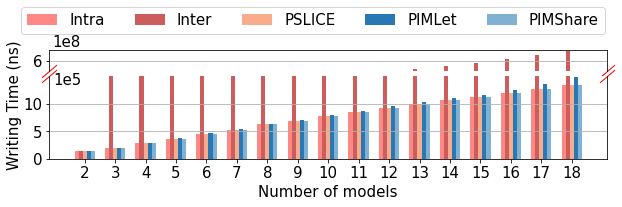

In [8]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10,2), gridspec_kw={'height_ratios': [1, 4]})
ax3 = fig.add_subplot(111, frameon=False)
names = nmrange
n_col = 5
width = 6
width_per_col = width/n_col
base_xticks = numpy.arange(len(names)) * (width+3)
ax1.bar(base_xticks-width/2, intra_write_time, width=width_per_col, label="Intra", color=color_map[0])
ax1.bar(base_xticks-width/2 + width_per_col, inter_write_time, width=width_per_col, label="Inter", color=color_map[1])
ax1.bar(base_xticks-width/2 + width_per_col*2, pslice_write_time, width=width_per_col, label="PSLICE", color=color_map[2])
ax1.bar(base_xticks-width/2 + width_per_col*3, pimlet_write_time, width=width_per_col, label="PIMLet", color=color_map[3])
ax1.bar(base_xticks-width/2 + width_per_col*4, our_write_time, width=width_per_col, label="PIMShare", color=color_map[4])

ax2.bar(base_xticks-width/2, intra_write_time, width=width_per_col, label="Intra", color=color_map[0])
ax2.bar(base_xticks-width/2 + width_per_col, inter_write_time, width=width_per_col, label="Inter", color=color_map[1])
ax2.bar(base_xticks-width/2 + width_per_col*2, pslice_write_time, width=width_per_col, label="PSLICE", color=color_map[2])
ax2.bar(base_xticks-width/2 + width_per_col*3, pimlet_write_time, width=width_per_col, label="PIMLet", color=color_map[3])
ax2.bar(base_xticks-width/2 + width_per_col*4, our_write_time, width=width_per_col, label="PIMShare", color=color_map[4])

ax1_ylim = (4e8, 8.1e8)
ax2_ylim = (0, 1.5e6)
ax1.set_xticks(ticks=base_xticks-width_per_col/2, labels=names,fontsize=fontsize)
ax1.set_yticks(ticks=[6e8], labels=[6], fontsize=fontsize)
ax1.text(-10.1, ax1_ylim[1]*1.1,"1e8",fontsize=fontsize)
ax2.set_xticks(ticks=base_xticks-width_per_col/2, labels=names, fontsize=fontsize)
ax2.set_yticks(ticks=[0, 5e5, 10e5], labels=[0, 5, 10], fontsize=fontsize)
ax2.text(-10, ax2_ylim[1]*0.9,"1e5",fontsize=fontsize)

ax2.set_ylim(ax2_ylim)
ax1.set_ylim(ax1_ylim)


ax1.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax1.tick_params(bottom=False)
ax1.grid(axis='y')
ax2.grid(axis='y')

d = .85
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=15,
              linestyle='none', color='r', mec='r', mew=1, clip_on=False)
ax1.plot([0, 1], [0, 0],transform=ax1.transAxes, **kwargs)
ax2.plot([0, 1], [1, 1], transform=ax2.transAxes, **kwargs)

ax3.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
ax2.set_xlabel("Number of models", fontsize=fontsize)
ax3.set_ylabel("Writing Time (ns)", fontsize=fontsize)
ax1.legend(loc=(-0.05, 1.8), ncol=5, fontsize=fontsize)
plt.subplots_adjust(wspace=0, hspace=0.1)

plt.show()

In [9]:
seed = 5
n_req = 20000
n_req_step = 10
n_req_start = 2000

multi_model_problem = ProblemInstance(neurosim_dir)
multi_model_problem.read_nn_profile(summary_file)
N_M = multi_model_problem.N_M
nxrange = numpy.arange(n_req_start, n_req+1, n_req_start)

x_intra_read_time = numpy.zeros_like(nxrange).astype(float)
x_inter_read_time = numpy.zeros_like(nxrange).astype(float)
x_pslice_read_time = numpy.zeros_like(nxrange).astype(float)
x_pimlet_read_time = numpy.zeros_like(nxrange).astype(float)
x_our_read_time = numpy.zeros_like(nxrange).astype(float)

x_intra_write_time = numpy.zeros_like(nxrange).astype(float)
x_inter_write_time = numpy.zeros_like(nxrange).astype(float)
x_pslice_write_time = numpy.zeros_like(nxrange).astype(float)
x_pimlet_write_time = numpy.zeros_like(nxrange).astype(float)
x_our_write_time = numpy.zeros_like(nxrange).astype(float)

for i, n_x in enumerate(tqdm(nxrange)):
    multi_model_problem.get_random_requests(n_x, seed=seed)
    
    plan_intra = bl_intra_1(multi_model_problem)
    time_intra = get_time(multi_model_problem, plan_intra)
    x_intra_read_time[i] = time_intra["read latency"]
    x_intra_write_time[i] = time_intra["write latency"]
    
    package_inter = bl_req_FCFS(multi_model_problem) 
    time_inter = multi_model_problem.running_time_decompose(*package_inter)
    x_inter_read_time[i] = time_inter["read latency"]
    x_inter_write_time[i] = time_inter["write latency"]
    
    plan_pslice = bl_pslice(multi_model_problem)
    time_pslice = get_time(multi_model_problem, plan_pslice)
    x_pslice_read_time[i] = time_pslice["read latency"]
    x_pslice_write_time[i] = time_pslice["write latency"]
    
    package_pimlet = bl_pimlet(multi_model_problem) 
    time_pimlet = multi_model_problem.running_time_decompose(*package_pimlet)
    x_pimlet_read_time[i] = time_pimlet["read latency"]
    x_pimlet_write_time[i] = time_pimlet["write latency"]
    
    plan_our = leader_follower(multi_model_problem)
    time_our = get_time(multi_model_problem, plan_our)
    x_our_read_time[i] = time_our["read latency"]
    x_our_write_time[i] = time_our["write latency"]

  0%|          | 0/10 [00:00<?, ?it/s]

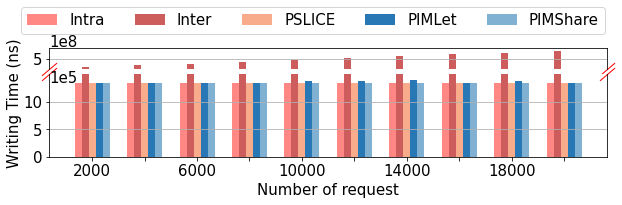

In [10]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10,2), gridspec_kw={'height_ratios': [1, 4]})
ax3 = fig.add_subplot(111, frameon=False)
names = nxrange
n_col = 5
width = 6
width_per_col = width/n_col
base_xticks = numpy.arange(len(names)) * (width+3)
ax1.bar(base_xticks-width/2, x_intra_write_time, width=width_per_col, label="Intra", color=color_map[0])
ax1.bar(base_xticks-width/2 + width_per_col, x_inter_write_time, width=width_per_col, label="Inter", color=color_map[1])
ax1.bar(base_xticks-width/2 + width_per_col*2, x_pslice_write_time, width=width_per_col, label="PSLICE", color=color_map[2])
ax1.bar(base_xticks-width/2 + width_per_col*3, x_pimlet_write_time, width=width_per_col, label="PIMLet", color=color_map[3])
ax1.bar(base_xticks-width/2 + width_per_col*4, x_our_write_time, width=width_per_col, label="PIMShare", color=color_map[4])

ax2.bar(base_xticks-width/2, x_intra_write_time, width=width_per_col, label="Intra", color=color_map[0])
ax2.bar(base_xticks-width/2 + width_per_col, x_inter_write_time, width=width_per_col, label="Inter", color=color_map[1])
ax2.bar(base_xticks-width/2 + width_per_col*2, x_pslice_write_time, width=width_per_col, label="PSLICE", color=color_map[2])
ax2.bar(base_xticks-width/2 + width_per_col*3, x_pimlet_write_time, width=width_per_col, label="PIMLet", color=color_map[3])
ax2.bar(base_xticks-width/2 + width_per_col*4, x_our_write_time, width=width_per_col, label="PIMShare", color=color_map[4])

ax1_ylim = (1e7, 1e9)
ax2_ylim = (0, 1.5e6)
ax1.set_xticks(ticks=base_xticks-width_per_col/2, labels=[n if i%2==0 else "" for i,n in enumerate(names)],fontsize=fontsize)
ax1.set_yticks(ticks=[5e8], labels=[5], fontsize=fontsize)
ax1.text(-8, ax1_ylim[1]*1.1,"1e8",fontsize=fontsize)
ax2.set_xticks(ticks=base_xticks-width_per_col/2, labels=[n if i%2==0 else "" for i,n in enumerate(names)], fontsize=fontsize)
ax2.set_yticks(ticks=[0, 5e5, 10e5], labels=[0, 5, 10], fontsize=fontsize)
ax2.text(-8, ax2_ylim[1]*0.9,"1e5",fontsize=fontsize)

ax2.set_ylim(ax2_ylim)
ax1.set_ylim(ax1_ylim)


ax1.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax1.tick_params(bottom=False)
ax1.grid(axis='y')
ax2.grid(axis='y')

d = .85
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=15,
              linestyle='none', color='r', mec='r', mew=1, clip_on=False)
ax1.plot([0, 1], [0, 0],transform=ax1.transAxes, **kwargs)
ax2.plot([0, 1], [1, 1], transform=ax2.transAxes, **kwargs)

ax3.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
ax2.set_xlabel("Number of request", fontsize=fontsize)
ax3.set_ylabel("Writing Time (ns)", fontsize=fontsize)
ax1.legend(loc=(-0.05, 1.7), ncol=5, fontsize=fontsize)
plt.subplots_adjust(wspace=0, hspace=0.1)

plt.show()